In [1]:
import numpy as np
import scipy as sc
import sys
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
from tensorflow_probability import bijectors as tfb
import time
import datetime
import matplotlib.pyplot as plt
import math as m
from sklearn import mixture
from scipy.optimize import minimize
from sklearn.datasets import make_moons
import utils as utl
from custom_bijectors import GMC_bijector, mv_GMM_icdf_bijector
sys.path.append('C:/Users/tewar/Documents/work/BNAF-master/data/')
%load_ext tensorboard

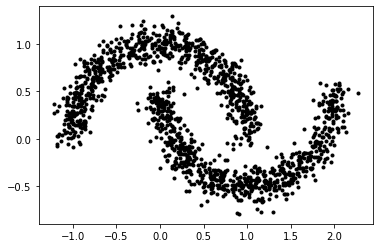

In [2]:
# Generating the samples from 2 moons
observations = make_moons(150000, noise=0.1)[0].astype("float64")
# observations = np.load('C:/Users/tewar/Documents/work/GMCM/data/power/data.npy')
# from gas import GAS
# gg=GAS('C:/Users/tewar/Documents/work/GMCM/data/gas/ethylene_CO.pickle')
# observations = gg.trn.x
# from power import POWER
# gg=POWER('C:/Users/tewar/Documents/work/GMCM/data/power/data.npy')
# observations = gg.trn.x


n_samps = observations.shape[0]
idx_selected = np.random.randint(0,n_samps,int(n_samps/100))
observations = observations[idx_selected,:]

plt.plot(observations[:,0],observations[:,1],'k.')
observations = tf.constant(observations,dtype=tf.float64)


In [3]:
# Specifying the sizes of training, test and validation datasets
n_train = int(0.70*np.shape(observations)[0])
n_valid = int(0.15*np.shape(observations)[0])
n_test = np.shape(observations)[0]-(n_train+n_valid)
print(f'Number of training samples = {n_train}')
print(f'Number of validation samples = {n_valid}')
print(f'Number of test samples = {n_test}')

Number of training samples = 1050
Number of validation samples = 225
Number of test samples = 225


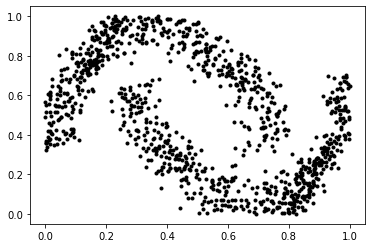

In [4]:
# Learning the marginal distribution first as a mixture of Gaussians distribution and outputting the marginal CDF values and vectorized marginal params
u_all,marg_params = utl.fitMargGMMs(observations,ncomps=20)
# Splitting the data in train,validation and test
u_train,u_valid,u_test = tf.split(u_all,[n_train,n_valid,n_test])
x_train,x_valid,x_test = tf.split(observations,[n_train,n_valid,n_test])

nsamps,ndims=np.shape(u_train)
n_marg_params = int(marg_params.shape.as_list()[0])
plt.plot(u_train[:,0],u_train[:,1],'k.')

In [31]:
@tf.function
def neg_logLikelihood_gmcm(theta_gmc,theta_marg,obs_data,reg_param=0.):
    # Defining the gmcm distribution
    gmcm_distribution = utl.vec2gmcm_dist(theta_gmc,theta_marg,ndims,ncomps)
    return  -tf.reduce_sum(gmcm_distribution.log_prob(obs_data)) + reg_param*tf.pow(tf.norm(utl.identifiabilityTransfrom(theta_gmc,ndims,ncomps)),2)

# Defining a function that returns the negative log-posterior and its gradients at a specified point (to be used in scipy.optimize.minimize  function)
def val_grad_func_gmcm(theta_gmc,theta_marg,obs_data,reg_param):
    negLL_gmcm = lambda th: neg_logLikelihood_gmcm(th,theta_marg,obs_data,reg_param)
    f,g = tfp.math.value_and_gradient(negLL_gmcm,tf.constant(theta_gmc)) # obtaiing the gradient using the  inbuilt function "value_and_gradient"
    g = tf.reshape(g,(tf.size(theta_gmc),))
    f = f.numpy().astype('float64') # conversion to float64 is necessary for scipy.minimize to work
    g = g.numpy().astype('float64') # conversion to float64 is necessary for scipy.minimize to work
    return f, g 


In [35]:
## Fitting the whole GMCM
# Specifying the number of dimensions and number of components to fit
ncomps =  4
# Initialize parameters of GMC distribution
np.random.seed(60)
theta_init_gmc =  utl.initGMCParams(observations.numpy(),ndims,ncomps,method='random')
theta_init_gmc = tf.constant(theta_init_gmc,dtype=tf.float64)
# theta_init_gmcm = tf.concat([marg_params,theta_init_gmc],axis=0)

In [49]:
## defining a callback function to show progress
def callbackF(th):
    neg_ll,_ = val_grad_func_gmcm(th,marg_params,x_valid,reg_param=0)
    print(neg_ll)
    
# theta_init=theta_init.numpy()

# Performing the optimization using Scipy Optimization library
start_time = time.time()
optim_results=minimize(val_grad_func_gmcm,theta_init_gmc,args=(marg_params,x_train,1000),method='L-BFGS-B',jac=True, options={"disp":True,"maxiter":200}, callback=callbackF)
end_time = time.time()

theta_final_gmc = tf.constant(optim_results.x)

# Printing various information about the optimizer
print('Time taken to obtain MAP using BFGS method: ' + str(np.round(end_time-start_time,decimals=2)) + ' s')
print('Total Iterations: ' + str(optim_results.nit))
print('Total Function Evals: ' + str(optim_results.nfev))
print('Converged: ' + str(optim_results.success))
print('fval at MAP: ' + str(optim_results.fun))

# Getting the likelihood of the GMCM
gmcm_dist_final = utl.vec2gmcm_dist(theta_final_gmc,marg_params,ndims,ncomps)
print(tf.reduce_mean(gmcm_dist_final.log_prob(observations)))

366.1954734558508
365.91731378366615
361.40938358318675
357.87226142190354
353.1756982661129
346.7495235908467
347.86713400363993
346.5037589271615
344.6657590205621
343.592710642898
340.65497919043133
338.8260548558393
337.5503758758941
335.3198684771717
336.0146654656549
335.4301844101409
333.67630259255213
334.06994186688155
333.5599706484882
332.76609268372215
331.70266740576136
331.56912706561775
331.20694672930824
330.82933885815294
330.7235293798166
330.53156402085705
330.3118970353391
329.93952383764673
329.2615163042167
328.6982979854556
328.48682157313755
327.04801058535674
325.36705580324707
324.6257651120113
324.6396199025973
324.6041376915334
324.01880076905184
323.06778380090583
322.9628748524114
321.9190733338648
321.21980050898105
320.68755804165033
320.3195188419745
320.0151313373796
319.7154505976297
319.47488191794133
319.3401183753728
319.2335440177004
319.18912344513745
319.1466391322189
319.19322065930965
319.4660365327478
319.5975681686304
319.88934373428526
320.

In [48]:
utl.identifiabilityTransfrom(theta_final_gmc,ndims,ncomps)

<tf.Tensor: shape=(4,), dtype=float64, numpy=array([-4.47337715e-04, -2.09860286e-04, -8.90871835e-05,  1.11767200e-03])>